## Imports and setup

In [135]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import imutils

In [136]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [137]:
img = cv.imread('wall.png', cv.IMREAD_UNCHANGED)
RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

## Look at original image

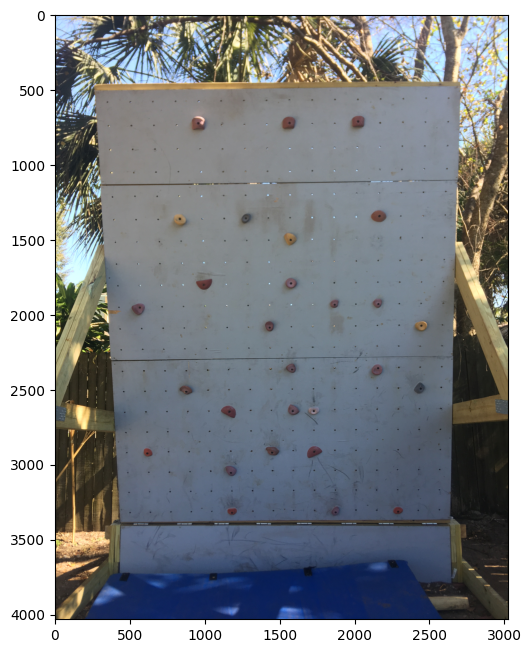

In [209]:
plt.imshow(RGB_img)

In [208]:
# plt.imshow(gray_img, cmap='gray', vmin=0, vmax=255)

## Resize img

In [138]:
orig = img.copy()
ratio = img.shape[0] / 300.0
img = imutils.resize(img, height=300)

## Apply bilateral filter to smooth out image

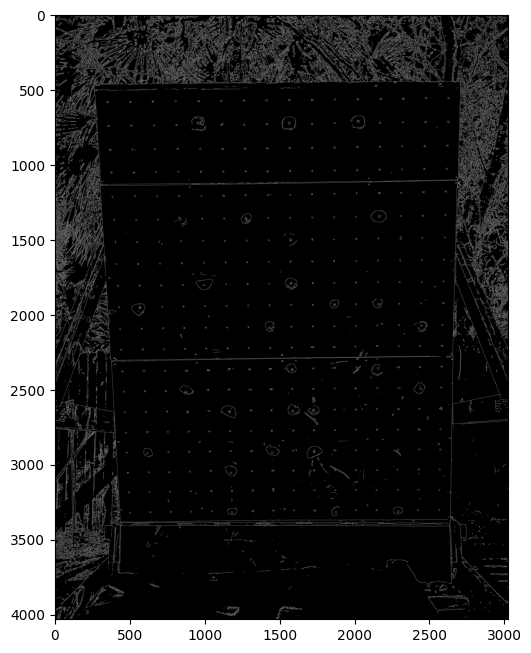

In [141]:
gray = cv.cvtColor(orig, cv.COLOR_BGR2GRAY)
gray = cv.bilateralFilter(gray, 11, 17, 17)
edged = cv.Canny(gray, 30, 25)

plt.imshow(edged, cmap='gray')

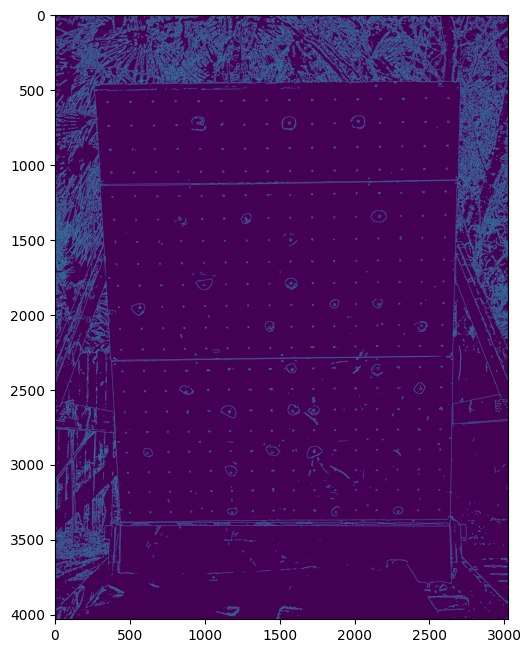

In [142]:
img_grey = edged
#set a thresh
thresh = 100
#get threshold image
ret,thresh_img = cv.threshold(img_grey, thresh, 255, cv.THRESH_BINARY)
# display thresh img
plt.imshow(thresh_img)

## find contours in image

In [143]:
#find contours
contours, hierarchy = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

#create an empty image for contours
img_contours = np.zeros(orig.shape, dtype=np.uint8)

(4032, 3024, 3)


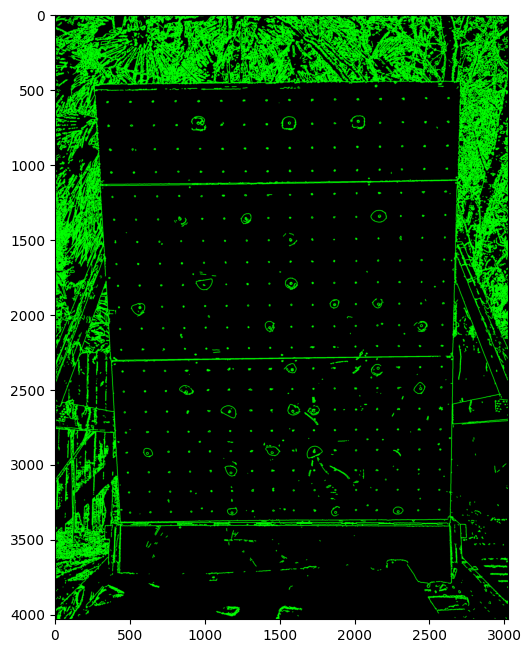

In [144]:
# draw the contours on the empty image
cv.drawContours(img_contours, contours, -1, (0,255,0), 3)
plt.imshow(img_contours)
print(img_contours.shape)

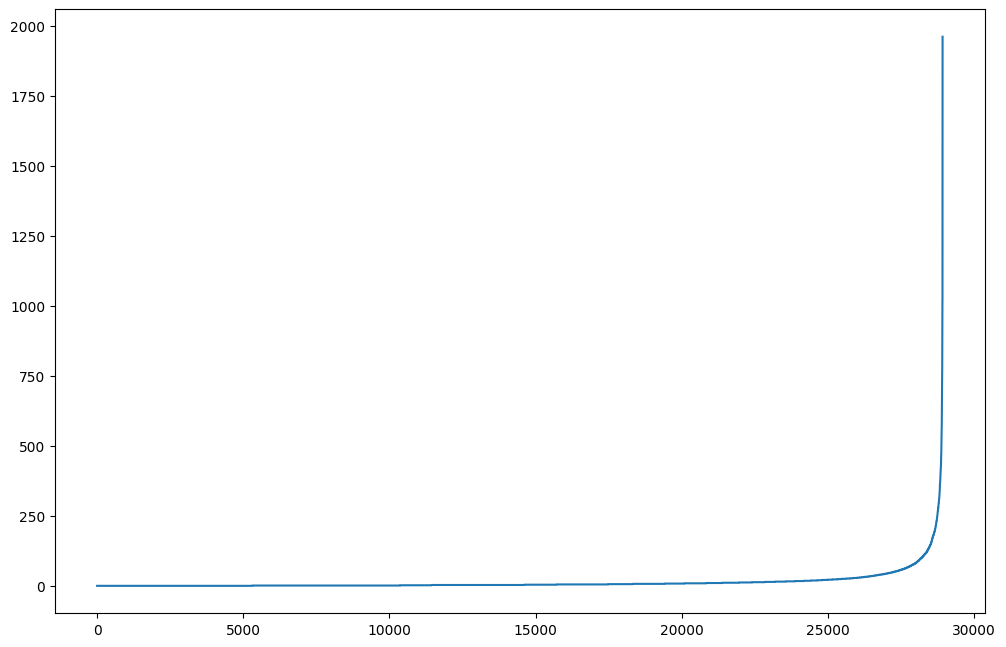

In [145]:
num_pts_per_cnt = [cnt.shape[0] for cnt in contours]
num_pts_per_cnt.sort()
plt.plot(num_pts_per_cnt)

In [146]:
# get strongest contours
num = 500
strongest_contours = sorted(contours, key=cv.contourArea, reverse=True)[:num]

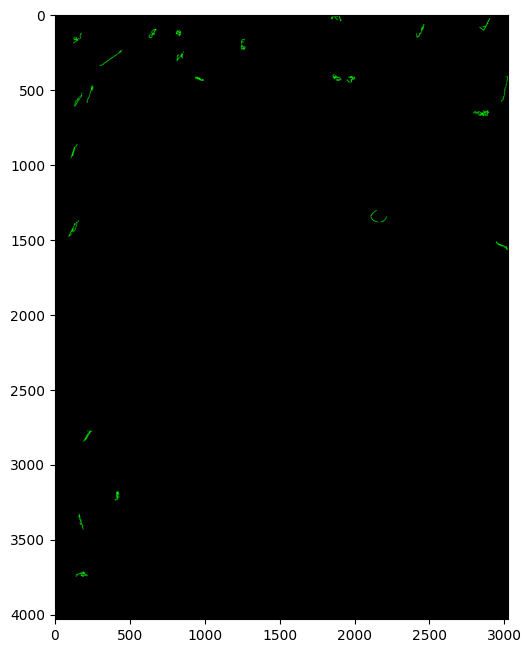

In [147]:
upper = 200
lower = 190
img_cnts = np.zeros(orig.shape, dtype=np.uint8)

for cnt in contours:
    if lower < cnt.shape[0] < upper:
        cv.drawContours(img_cnts, cnt, -1, (0,255,0), 3)
plt.imshow(img_cnts)

In [148]:
# # for i, cnt in enumerate(strongest_contours):
# for i, cnt in reversed(list(enumerate(strongest_contours))):
#     if i == num-10:
#         break
#     plt.figure()
    
#     #create an empty image for contours
#     img_cnts = np.zeros(orig.shape, dtype=np.uint8)
    
#     cv.drawContours(img_cnts, cnt, -1, (0,255,0), 3)
#     plt.imshow(img_cnts)

# # cv.drawContours(img_cnts, strongest_contours, -1, (0,255,0), 3)
# # plt.imshow(img_cnts)

## Detect corners of wall

[[[2814. 1067.]]

 [[2794.  981.]]

 [[2878.  938.]]

 [[2436.  127.]]]


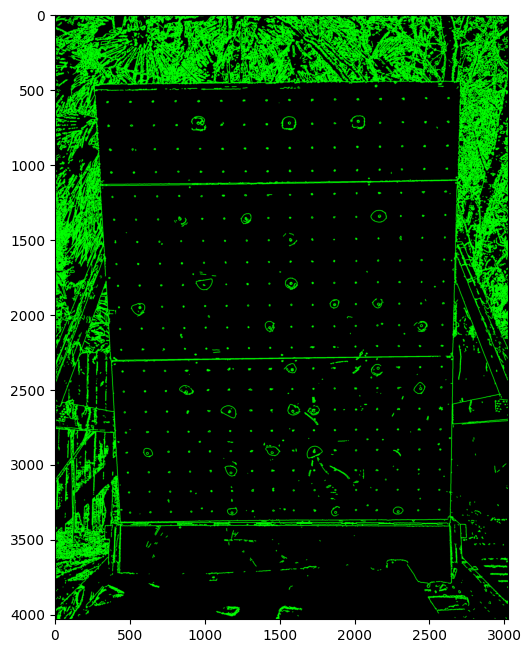

In [199]:
img_corners = np.array(img_contours, dtype=np.uint8)
gray = cv.cvtColor(img_corners, cv.COLOR_BGR2GRAY)
canny = cv.Canny(gray, 120, 255, 1)
corners = cv.goodFeaturesToTrack(canny,4,0.5,50)

# for corner in corners:
#     x,y = corner.ravel()
#     cv.circle(img,(x,y),50,(0,0,255),-1)

print(corners)
    
plt.imshow(img_corners)

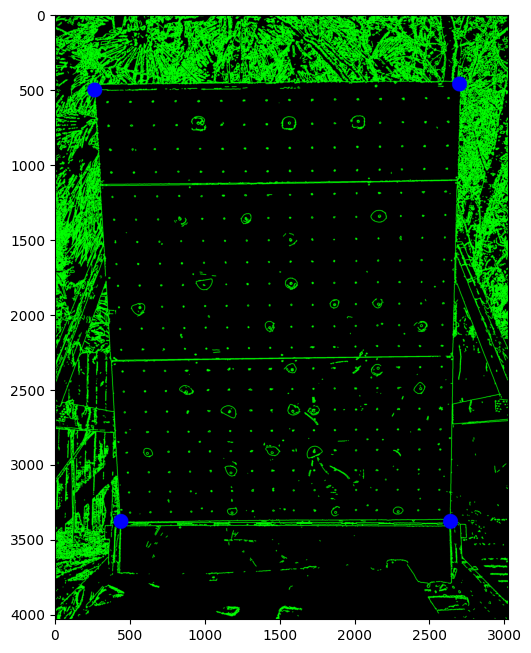

In [197]:
img_corners_bf = np.array(img_contours, dtype=np.uint8)

# ul, ur, ll, lr
bf_corners = np.array([
    [[265, 500]],
    [[2700, 460]],
    [[440, 3380]],
    [[2640, 3380]],
])
for corner in bf_corners:
    x,y = corner.ravel()
    cv.circle(img_corners,(x,y),50,(0,0,255),-1)
    
plt.imshow(img_corners)

## Straighten image (https://stackoverflow.com/questions/41995916/opencv-straighten-an-image-with-python)

[[ 265  500]
 [2700  460]
 [ 440 3380]
 [2640 3380]]
(4032, 3024, 3)


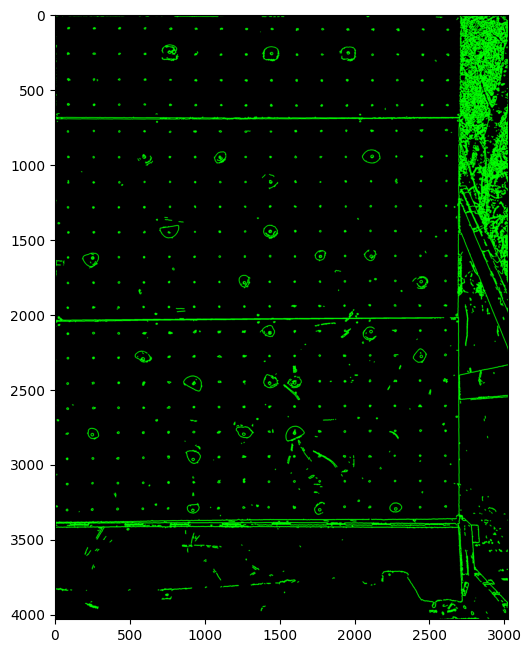

In [200]:
#---- 4 corner points of the bounding box
pts_src = np.array([pt.ravel() for pt in bf_corners])
print(pts_src)

#---- 4 corner points of the black image you want to impose it on
dx = pts_src[1][0]
dy = pts_src[2][1]
pts_dst = np.array([[0.0,0.0], [dx,0.0], [0.0,dy],[dx, dy]])

#---- forming the black image of specific size
im_dst = np.zeros(img_contours.shape, np.uint8)

#---- Framing the homography matrix
h, status = cv.findHomography(pts_src, pts_dst)

#---- transforming the image bound in the rectangle to straighten
im_out = cv.warpPerspective(img_contours, h, (im_dst.shape[1],im_dst.shape[0]))
# cv2.imwrite("im_out.jpg", im_out)

plt.imshow(im_out)

print(im_out.shape)

# Apply mask to image based on corners of wall

## Create mask

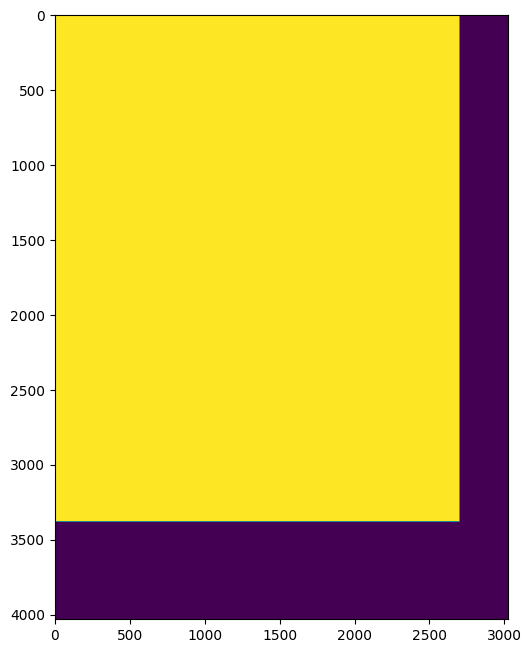

In [201]:
# def draw_rect(img, pts):
#     for i in range(len(pts)):
#         p1 = tuple(pts[i-1].ravel())
#         p2 = tuple(pts[i].ravel())
#         cv.line(img, p1, p2, (255,0,0), 10)

def pt_in_rect(pt, dx, dy):
    # numpy reverses ordering of rows and cols
    return pt[0] <= dy and pt[1] <= dx

def create_filled_rect(img, pts, dx, dy):
    for i,row in enumerate(img):
        for j, col in enumerate(row):
            if pt_in_rect([i,j], dx, dy):
                img[i,j] = 1
            else:
                img[i,j] = 0
    
    return img

# draw_rect(img, bf_corners)
# plt.imshow(img)

mask = np.zeros(im_out.shape[:2], dtype=np.uint8)
mask = create_filled_rect(mask, pts_dst, dx, dy)
plt.imshow(mask)

## Apply mask

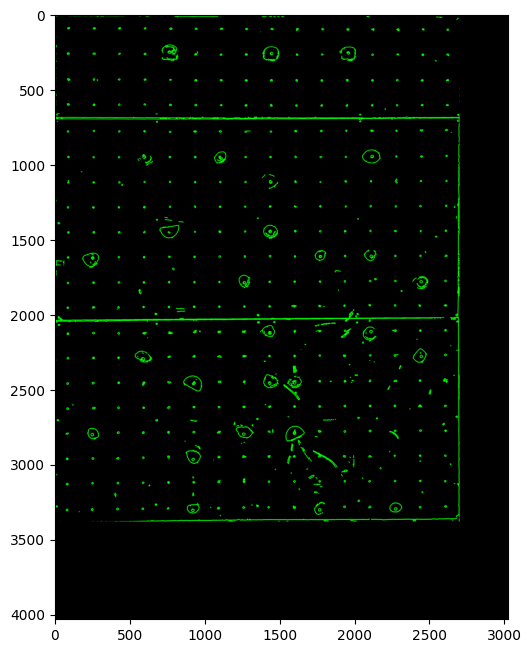

In [205]:
# mask defined above

img = im_out

# Create new image
# Case #1 - Other image is grayscale and source image is colour
if len(img.shape) == 3 and len(mask.shape) != 3:
    new_image = img * (mask[:,:,None].astype(img.dtype))
# Case #2 - Both images are colour or grayscale
elif (len(img.shape) == 3 and len(mask.shape) == 3) or \
   (len(img.shape) == 1 and len(mask.shape) == 1):
    new_image = img * (mask.astype(img.dtype))
# Otherwise, we can't do this
else:
    raise Exception("Incompatible input and mask dimensions")

plt.imshow(new_image)

## Simply crop image

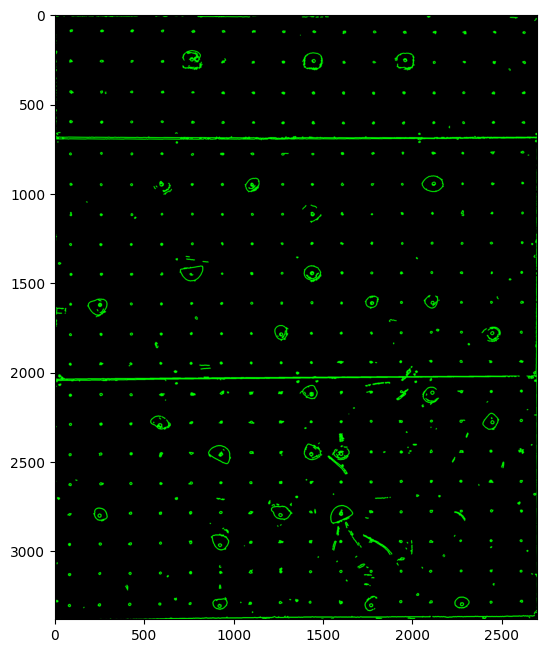

In [207]:
crop_img = im_out[:dy, :dx]
plt.imshow(crop_img)